In [1]:
import os
os.chdir('/home/berling/reduce_opto_response/')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from article_figures.article_plot_functions import plot_morphology_with_light, spatial_activation_plot, map_patt_id_2_xy, label_subplots_ABC

In [2]:
# load pre-simulated spatial activation maps
df = pd.read_csv('snake_workflow/result--L23_PC_cADpyr229_1_d50_NA01.csv', index_col='Unnamed: 0')
df_full = df.loc[(df.simtype=='full')]
df_RON_full = df.loc[(df.simtype=='RON_full')]
df_RON_adex = df.loc[(df.simtype=='RON_adex')]
merge = df_RON_full.merge(df_RON_adex, on=['patt_id','norm_power_mW_of_MultiStimulator', 'cond_scale_factor'])
merge = merge.loc[merge.patt_id==230]

In [3]:
def process_directory(directory):
    # Pattern with capture groups for patt_id and norm_power
    pattern = re.compile(
        r'slp-id230-xymax_110-dxy_10-norm_power_(?P<norm_power>[0-9eE\.-]+)-cluster_50-cond_scale_fct0\.15\.npy$'
    )

    results = []
    conds = dict()
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            file_path = os.path.join(directory, filename)
            try:
                array = np.load(file_path)
                if array.shape == (1, 250):
                    array_sum = array.sum()
                    norm_power = float(match.group('norm_power'))
                    conds[norm_power] = array[0]
                    results.append({
                        'cond': array_sum,
                        'norm_power': norm_power
                    })
                else:
                    print(f"Skipping {filename}: incorrect shape {array.shape}")
            except Exception as e:
                print(f"Error loading {filename}: {e}")

    df = pd.DataFrame(results)
    return df, conds
df, conds = process_directory('snake_workflow/simulated_data/RON_cond/L23_PC_cADpyr229_1/')
df = df.rename(columns=dict(norm_power='norm_power_mW_of_MultiStimulator'))
cond_merge = merge.merge(df, on=['norm_power_mW_of_MultiStimulator'])

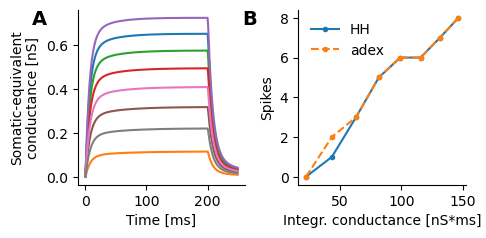

In [6]:
# figure format
a4_w = 8.27
a4_l = 11.7
fig, [ax1,ax2] = plt.subplots(ncols=2, figsize=(a4_w*0.6, a4_w*0.3))

for norm_power in conds.keys():
    ax1.plot(np.arange(0,250), conds[norm_power])
ax1.set_xlabel('Time [ms]')
ax1.set_ylabel('Somatic-equivalent\nconductance [nS]')

ax2.plot(cond_merge.cond.values, cond_merge.APC_x.values, marker='.', ls='solid', label='HH')
ax2.plot(cond_merge.cond.values, cond_merge.APC_y.values, marker='.', ls='dashed', label='adex')
ax2.set_xlabel('Integr. conductance [nS*ms]')
ax2.set_ylabel('Spikes')
ax2.legend(frameon=False)

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
label_subplots_ABC(fig, axs=[ax1, ax2], x_shift=-0.05, y_shift=0, fontsize=14, weight='bold')

plt.tight_layout()
fig.savefig('article_figures/figures/fit_adex_to_HH_L23_PC_1.png', facecolor='white', dpi=300)